# Importing the Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import pickle
import numpy as np
import streamlit as st
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
print("Python version:", sys.version)


Python version: 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


In [ ]:
file_path = 'D:\\Projects\\Mini_Projects\\Mental_Health_Survey\\Research_Data\\train.csv'

In [ ]:
data = pd.read_csv(file_path)

In [ ]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
data.shape

(140700, 20)

In [ ]:
data.drop(['id','Name'], axis = 1, inplace = True)

In [ ]:
data.columns

Index(['Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working Professional or Student        140700 non-null  object 
 4   Profession                             104070 non-null  object 
 5   Academic Pressure                      27897 non-null   float64
 6   Work Pressure                          112782 non-null  float64
 7   CGPA                                   27898 non-null   float64
 8   Study Satisfaction                     27897 non-null   float64
 9   Job Satisfaction                       112790 non-null  float64
 10  Sleep Duration                         140700 non-null  

In [ ]:
# target value counts

data['Depression'].value_counts()

Depression
0    115133
1     25567
Name: count, dtype: int64

In [ ]:
depressed_gender = data[data['Depression'] == 1].groupby('Gender')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_gender = data[data['Depression'] == 0].groupby('Gender')['Depression'].count().sort_values(ascending = False).reset_index()

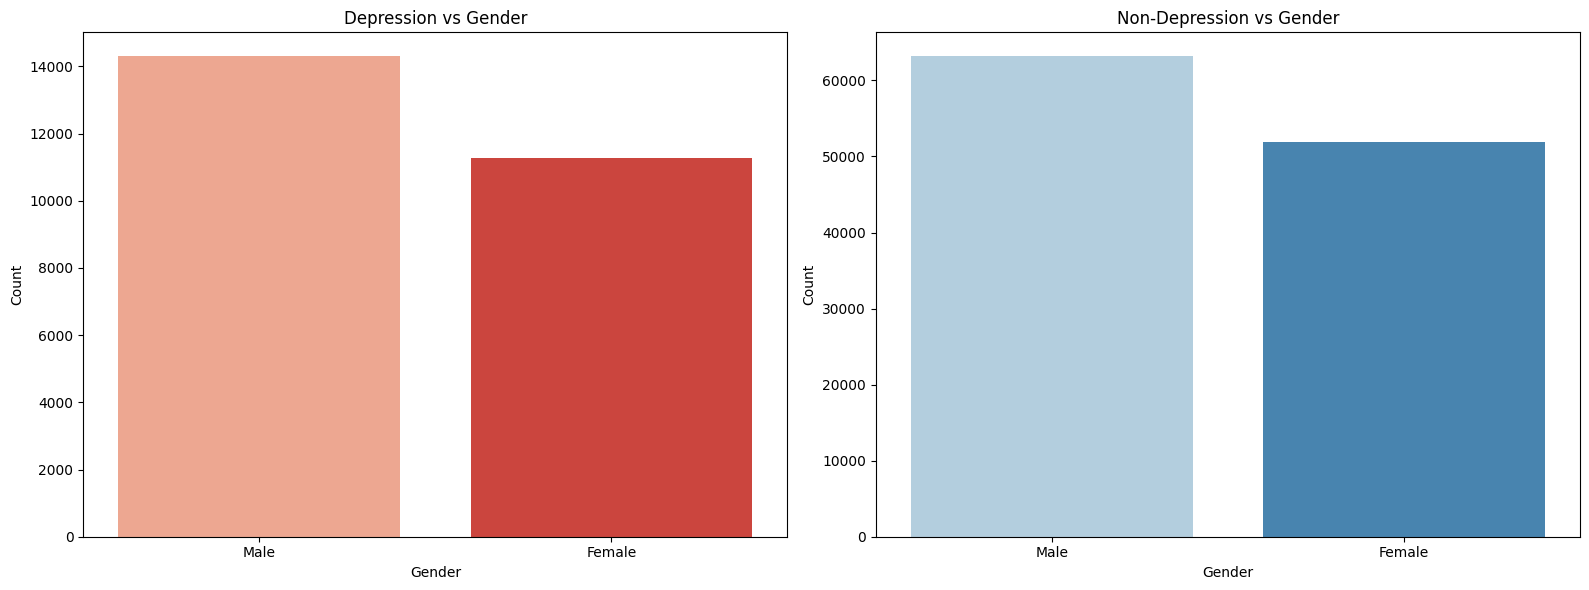

In [ ]:
# Set Streamlit page config
st.set_page_config(page_title="Mental Health Depression Prediction", layout="wide")

def img_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()

# Apply background image
image_path = r"D:\\Projects\\Mini_Projects\\Mental_Health_Survey\\Image\\Neural_Networks.jpg"
try:
    img_base64 = img_to_base64(image_path)
    st.markdown(f"""
        <style>
        .stApp {{
            background-image: linear-gradient(rgba(0, 0, 0, 0.7), rgba(0, 0, 0, 0.7)), url('data:image/jpeg;base64,{img_base64}');
            background-size: cover;
            background-position: center;
            background-repeat: no-repeat;
            padding: 0;
        }}
        .title-container {{
            text-align: center;
            color: white;
            font-size: 4em;
            margin-top: 350px;
        }}
        </style>
    """, unsafe_allow_html=True)
except FileNotFoundError:
    st.error("Image not found at the specified path.")

class MentalHealthPreprocessor:
    def _init_(self):
        self.encoders = {}
        self.columns_to_drop = []
        self.numerical_features = []
        self.categorical_features = []

    def fit(self, data):
        self.numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
        self.categorical_features = data.select_dtypes(include=["object"]).columns.tolist()

        corr_matrix = data[self.numerical_features].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.columns_to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.6)]
        data = data.drop(columns=self.columns_to_drop, errors="ignore")
        self.numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

        for col in self.categorical_features:
            if col in data.columns:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
                self.encoders[col] = le

        return data

    def ensure_all_features(self, data):
        for col in self.numerical_features:
            data[col] = data.get(col, 0)
        for col in self.categorical_features:
            data[col] = data.get(col, 0)
        return data[self.numerical_features + [col for col in self.categorical_features if col in self.encoders]]

    def transform(self, data):
        data = data.drop(columns=self.columns_to_drop, errors="ignore")
        for col in self.categorical_features:
            if col in data.columns and col in self.encoders:
                try:
                    data[col] = self.encoders[col].transform(data[col].astype(str))
                except ValueError:
                    data[col] = 0
        return self.ensure_all_features(data)

@st.cache_resource
def load_pickle(path, default=None):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        st.error(f"Error loading file: {str(e)}")
        return default

@st.cache_resource
def load_model():
    try:
        return tf.keras.models.load_model(r"D:\Projects\Mini_Projects\Mental_Health_Survey\Model\neural_network.keras")
    except Exception as e:
        st.error(f"Error loading model: {str(e)}")
        return None

@st.cache_resource
def load_cleaning():
    return load_pickle(r"D:\\Projects\\Mini_Projects\\Mental_Health_Survey\\Model\\cleaning.pkl", pd.DataFrame())

def predict_depression(input_data, model, preprocessor):
    try:
        processed = preprocessor.transform(pd.DataFrame([input_data]))
        processed = np.pad(processed, ((0, 0), (0, max(0, 13 - processed.shape[1]))), mode='constant')
        processed = processed[:, :13]
        output = model.predict(processed)
        label = "Depression Detected" if output[0] > 0.5 else "No Depression"
        return label, output[0][0]
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")
        return "Error", 0.0

# Sidebar and page routing
st.title("Mental Health Depression Prediction Application")
st.sidebar.header("Navigation")
page = st.sidebar.radio("Select Page", ["Home", "Upload Data", "Manual Entry", "Visualizations", "Bias_Evaluation"])

if "predicted_data" not in st.session_state:
    st.session_state.predicted_data = pd.DataFrame()

if page == "Home":
    st.subheader("Understanding Depression")
    st.markdown("""
        Depression is a serious mental health disorder that affects mood, thought, and behavior.
        This application allows prediction of depression based on user input or uploaded survey data.
        If you or someone you know is struggling, seek help—you're not alone.
    """)

elif page == "Upload Data":
    st.header("Upload Survey CSV")
    file = st.file_uploader("Upload CSV", type="csv")
    if file:
        df = pd.read_csv(file)
        st.write("### Raw Data", df.head())

        cleaned = load_cleaning()
        preprocessor = MentalHealthPreprocessor()
        model = load_model()

        preprocessor.fit(cleaned.copy())
        processed = preprocessor.transform(df.copy())
        processed = np.pad(processed, ((0, 0), (0, max(0, 13 - processed.shape[1]))), mode='constant')
        processed = processed[:, :13]

        if st.button("Predict"):
            predictions = model.predict(processed)
            result = df.copy()
            result["Prediction"] = (predictions > 0.5).astype(int)
            result["Confidence"] = predictions.round(2)

            st.session_state.predicted_data = result
            st.write("### Results", result.head())

            csv = result.to_csv(index=False).encode('utf-8')
            st.download_button("Download Results", data=csv, file_name="depression_predictions.csv")

elif page == "Manual Entry":
    st.header("Manual Survey Input")

    input_data = {
        "Gender": st.selectbox("Gender", ["Male", "Female"]),
        "Age": st.slider("Age", 18, 80),
        "City": st.selectbox("City", ["Mumbai", "Delhi", "Chennai"]),
        "Sleep Duration": st.selectbox("Sleep Duration", ["6-8 hours", "Less than 5 hours", "More than 8 hours"]),
        "Dietary Habits": st.selectbox("Dietary Habits", ["Healthy", "Moderate", "Unhealthy"]),
        "Have you ever had suicidal thoughts ?": st.selectbox("Suicidal Thoughts?", ["Yes", "No"]),
        "Work/Study Hours": st.slider("Work/Study Hours", 0, 24),
        "Financial Stress": st.slider("Financial Stress", 0, 5),
        "Family History of Mental Illness": st.selectbox("Family History?", ["Yes", "No"]),
    }

    role = st.radio("Are you a...", ["Professional", "Student"])
    if role == "Professional":
        input_data.update({
            "Profession": st.selectbox("Profession", ["Software Engineer", "Doctor", "Teacher"]),
            "Work Pressure": st.slider("Work Pressure", 0, 10),
            "Job Satisfaction": st.slider("Job Satisfaction", 0, 10),
        })
    else:
        input_data.update({
            "Academic Pressure": st.slider("Academic Pressure", 0, 10),
            "CGPA": st.number_input("CGPA", 0.0, 10.0),
            "Study Satisfaction": st.slider("Study Satisfaction", 0, 10),
            "Degree": st.selectbox("Degree", ["BSc", "BA", "B.Tech"]),
        })

    if st.button("Predict"):
        model = load_model()
        preprocessor = MentalHealthPreprocessor()
        cleaned = load_cleaning()
        preprocessor.fit(cleaned.copy())
        pred, conf = predict_depression(input_data, model, preprocessor)
        st.success(f"Prediction: {pred}")
        st.info(f"Confidence Score: {conf:.2f}")

elif page == "Visualizations":
    st.header("Data Insights & Visualizations")
    preprocessor = MentalHealthPreprocessor()
    model = load_model()
    cleaned_data = load_cleaning()

    preprocessor.fit(cleaned_data.copy())
    preprocessed_data = preprocessor.transform(cleaned_data.copy())

    if preprocessed_data.shape[1] > 13:
        preprocessed_data = preprocessed_data.iloc[:, :13]

    if not st.session_state["predicted_data"].empty:
        st.write("#### Predicted Data Overview")
        st.dataframe(st.session_state["predicted_data"].head())

        numeric_data = st.session_state["predicted_data"].select_dtypes(include=[np.number])

        if not numeric_data.empty:
            st.write("#### Correlation Heatmap (Predicted Data)")
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", ax=ax)
            st.pyplot(fig)

        st.write("#### Depression Distribution in Predictions")
        fig2, ax2 = plt.subplots()
        sns.countplot(x="Prediction", data=st.session_state["predicted_data"], ax=ax2)
        st.pyplot(fig2)
    else:
        st.warning("No predicted data available. Please run predictions in the Upload Data section first.")

elif page == "Bias_Evaluation":
    st.header("Bias Evaluation for Prediction Distribution")
    if "predicted_data" in st.session_state and not st.session_state["predicted_data"].empty:
        data = st.session_state["predicted_data"].copy()
    else:
        st.warning("No predicted data available. Please run predictions in the Upload Data section first.")
        st.stop()

    if "Gender" in data.columns and "Prediction" in data.columns:
        st.write("#### Gender Distribution in Predictions")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.countplot(x="Gender", hue="Prediction", data=data, ax=ax)
        st.pyplot(fig)

        gender_stats = data.groupby("Gender")["Prediction"].mean().reset_index()
        gender_stats.columns = ["Gender", "Depression Prediction Rate"]
        fig2, ax2 = plt.subplots(figsize=(8, 5))
        sns.barplot(x="Gender", y="Depression Prediction Rate", data=gender_stats, ax=ax2)
        plt.ylim(0, 1)
        st.pyplot(fig2)
        st.dataframe(gender_stats)

    if "Age" in data.columns and "Prediction" in data.columns:
        st.write("#### Age Distribution in Predictions")
        data["Age Group"] = pd.cut(data["Age"], bins=[17, 25, 35, 45, 55, 85], labels=["18-25", "26-35", "36-45", "46-55", "56+"])
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        sns.countplot(x="Age Group", hue="Prediction", data=data, ax=ax3)
        st.pyplot(fig3)

        age_stats = data.groupby("Age Group")["Prediction"].mean().reset_index()
        age_stats.columns = ["Age Group", "Depression Prediction Rate"]
        fig4, ax4 = plt.subplots(figsize=(10, 5))
        sns.barplot(x="Age Group", y="Depression Prediction Rate", data=age_stats, ax=ax4)
        plt.ylim(0, 1)
        st.pyplot(fig4)
        st.dataframe(age_stats)

    for factor in ["City", "Sleep Duration", "Dietary Habits", "Work/Study Hours"]:
        if factor in data.columns and "Prediction" in data.columns:
            st.write(f"#### {factor} Distribution in Predictions")
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.countplot(x=factor, hue="Prediction", data=data, ax=ax)
        st.pyplot(fig)fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_gender, x='Gender', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

sns.barplot(data=non_depressed_gender, x='Gender', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
# Group by Age and count the number of depressed and non-depressed individuals


depressed_age = data[data['Depression'] == 1].groupby('Age')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_age = data[data['Depression'] == 0].groupby('Age')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

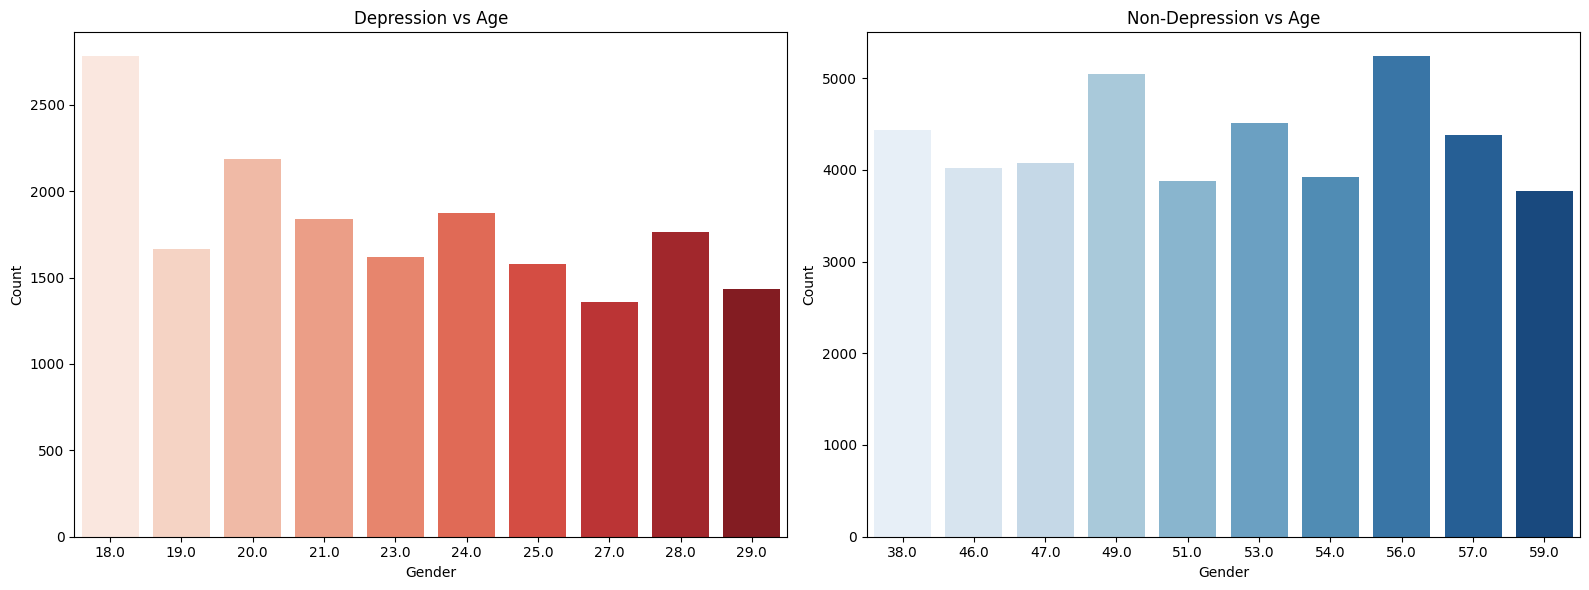

In [ ]:
# Depressed vs Non-Depressed Age Distribution with Bar Plot

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_age, x='Age', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Age")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

sns.barplot(data=non_depressed_age, x='Age', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Age")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
depressed_city = data[data['Depression'] == 1].groupby('City')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_city = data[data['Depression'] == 0].groupby('City')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

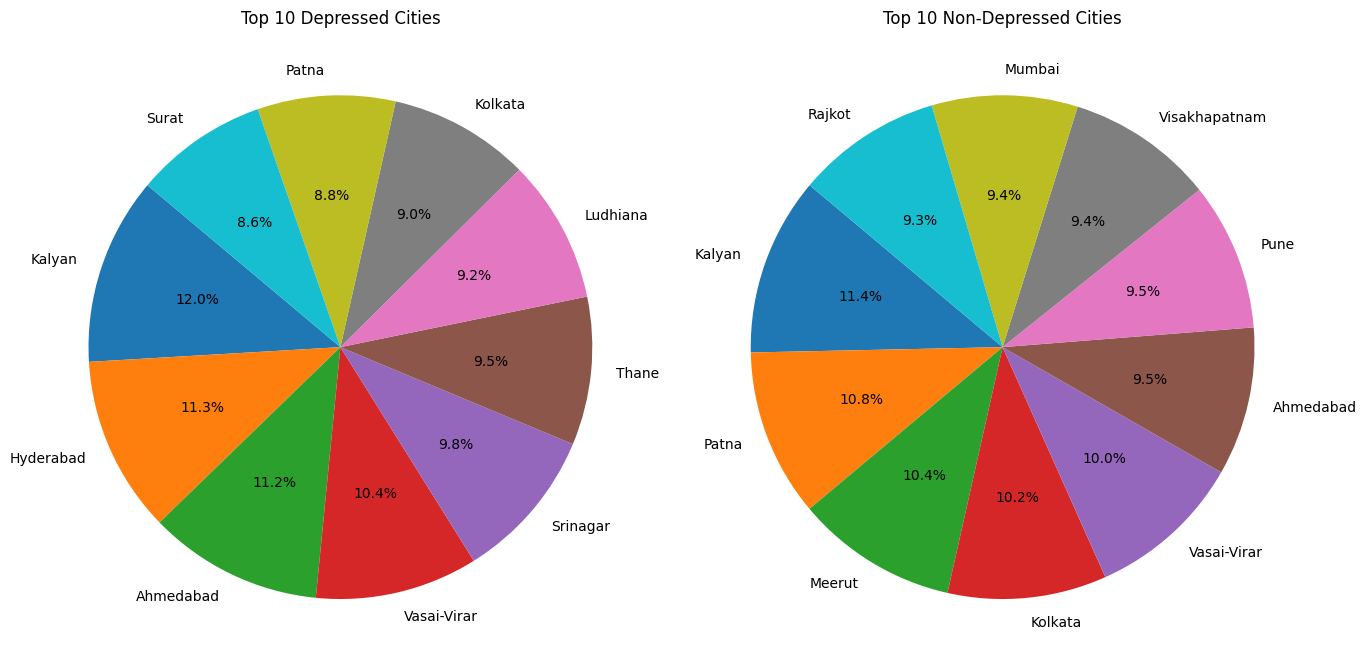

In [ ]:
# Pie chart for top 10 depressed and non-depressed cities

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

axes[0].pie(
    depressed_city['Depression'],  
    labels=depressed_city['City'],
    autopct='%1.1f%%',  
    startangle=140
)
axes[0].set_title("Top 10 Depressed Cities")

axes[1].pie(
    non_depressed_city['Depression'],  
    labels=non_depressed_city['City'],
    autopct='%1.1f%%',  
    startangle=140  
)
axes[1].set_title("Top 10 Non-Depressed Cities")

plt.tight_layout()
plt.show()

In [ ]:
depressed_job = data[data['Depression'] == 1].groupby('Profession')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_job = data[data['Depression'] == 0].groupby('Profession')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

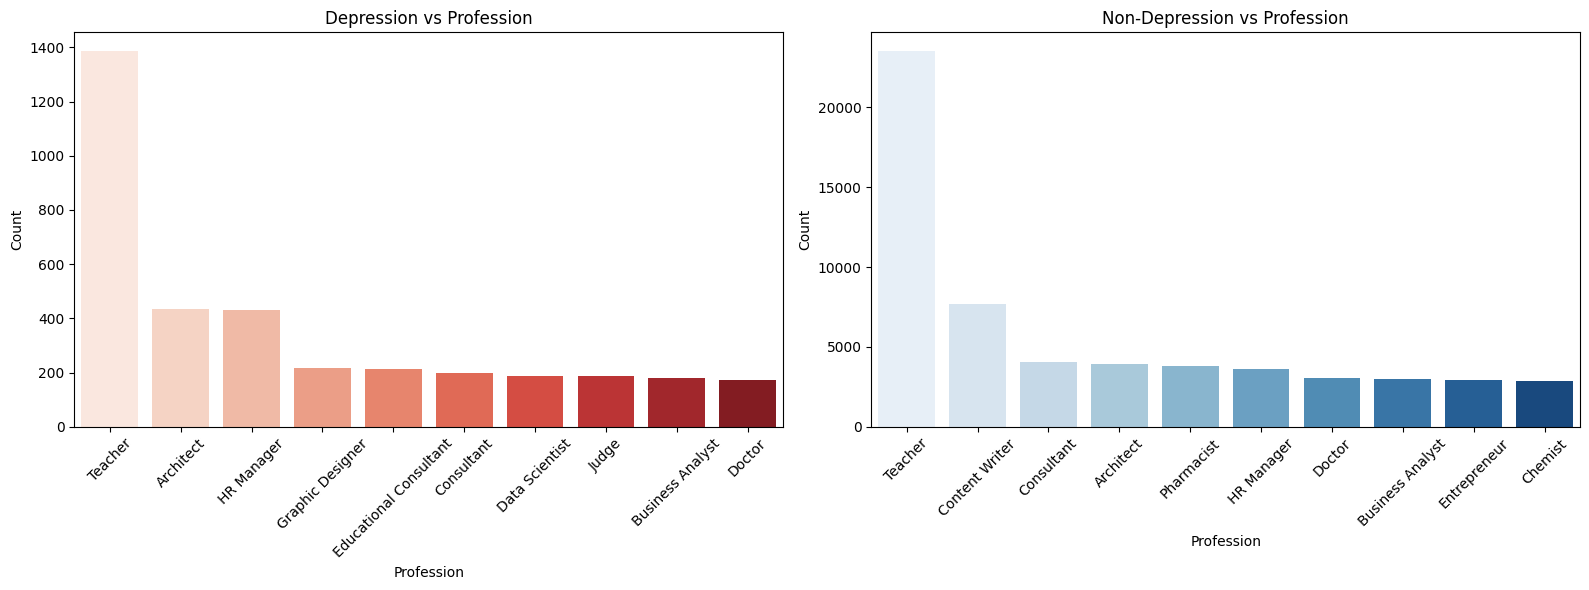

In [ ]:
# Bar plot for Depressed and Non-Depressed Jobs

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_job, x='Profession', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Profession")
axes[0].set_xlabel("Profession")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=non_depressed_job, x='Profession', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Profession")
axes[1].set_xlabel("Profession")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def categorize_sleep(duration):
    duration = duration.lower()
    
    if any(x in duration for x in ["less than 5", "1-2", "2-3", "3-4", "4-5", "than 5"]):
        return "Less than 5 hours"
    elif any(x in duration for x in ["5-6", "4-6", "3-6", "6-7", "1-6"]):
        return "5-6 hours"
    elif any(x in duration for x in ["7-8", "6-8", "8 hours"]):
        return "6-8 hours"
    elif any(x in duration for x in ["more than 8", "8-9", "9-11", "10-11"]):
        return "More than 8 hours"
    else:
        return "Invalid"
    
data['Sleep Duration'] = data['Sleep Duration'].apply(categorize_sleep)
data.drop(data[data['Sleep Duration']=='Invalid'].index, inplace = True)

In [ ]:
depressed_sleep_cycle = data[data['Depression'] == 1].groupby('Sleep Duration')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_sleep_cycle = data[data['Depression'] == 0].groupby('Sleep Duration')['Depression'].count().sort_values(ascending = False).reset_index()

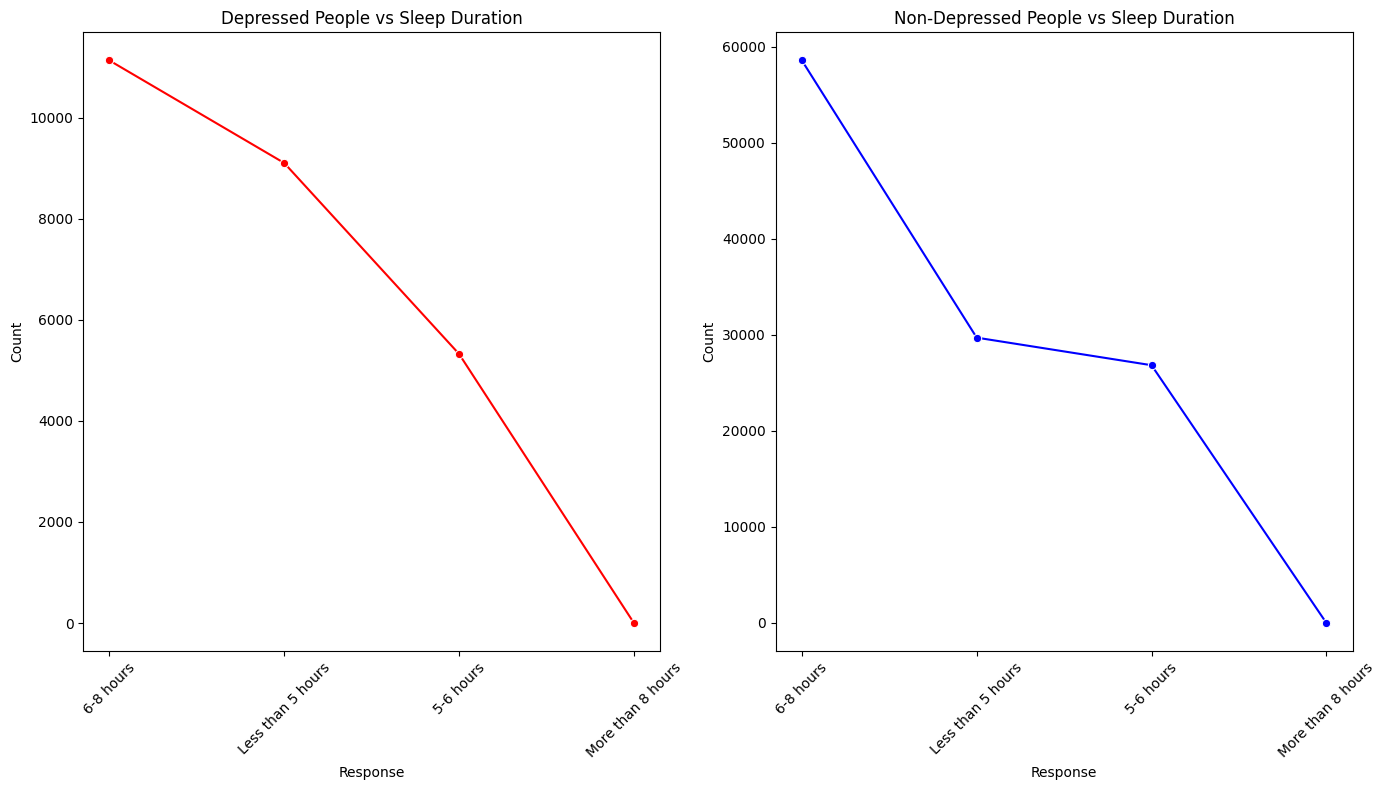

In [ ]:
# Sleep Cycle Distribution with Line Plot

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.lineplot(
    data=depressed_sleep_cycle, 
    x='Sleep Duration', 
    y='Depression', 
    marker='o', 
    color='red', 
    ax=axes[0]
)
axes[0].set_title("Depressed People vs Sleep Duration")
axes[0].set_xlabel("Response")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(
    data=non_depressed_sleep_cycle, 
    x='Sleep Duration', 
    y='Depression', 
    marker='o', 
    color='blue', 
    ax=axes[1]
)
axes[1].set_title("Non-Depressed People vs Sleep Duration")
axes[1].set_xlabel("Response")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def categorize_diet(habit):
    
    if pd.isna(habit):  
        return "Invalid"

    habit = str(habit).lower().strip() 

    words = habit.split() 

    if any(x in words for x in ["healthy", "more healthy"]):
        return "Healthy"
    elif "moderate" in words:
        return "Moderate"
    elif any(x in words for x in ["unhealthy", "less healthy", "less than healthy", "no healthy"]):
        return "Unhealthy"
    else:
        return "Invalid"
    
data['Dietary Habits'] = data['Dietary Habits'].apply(categorize_diet)
data.drop(data[data['Dietary Habits'] == 'Invalid'].index, inplace = True)

In [ ]:
depressed_diet = data[data['Depression'] == 1].groupby('Dietary Habits')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_diet = data[data['Depression'] == 0].groupby('Dietary Habits')['Depression'].count().sort_values(ascending = False).reset_index()

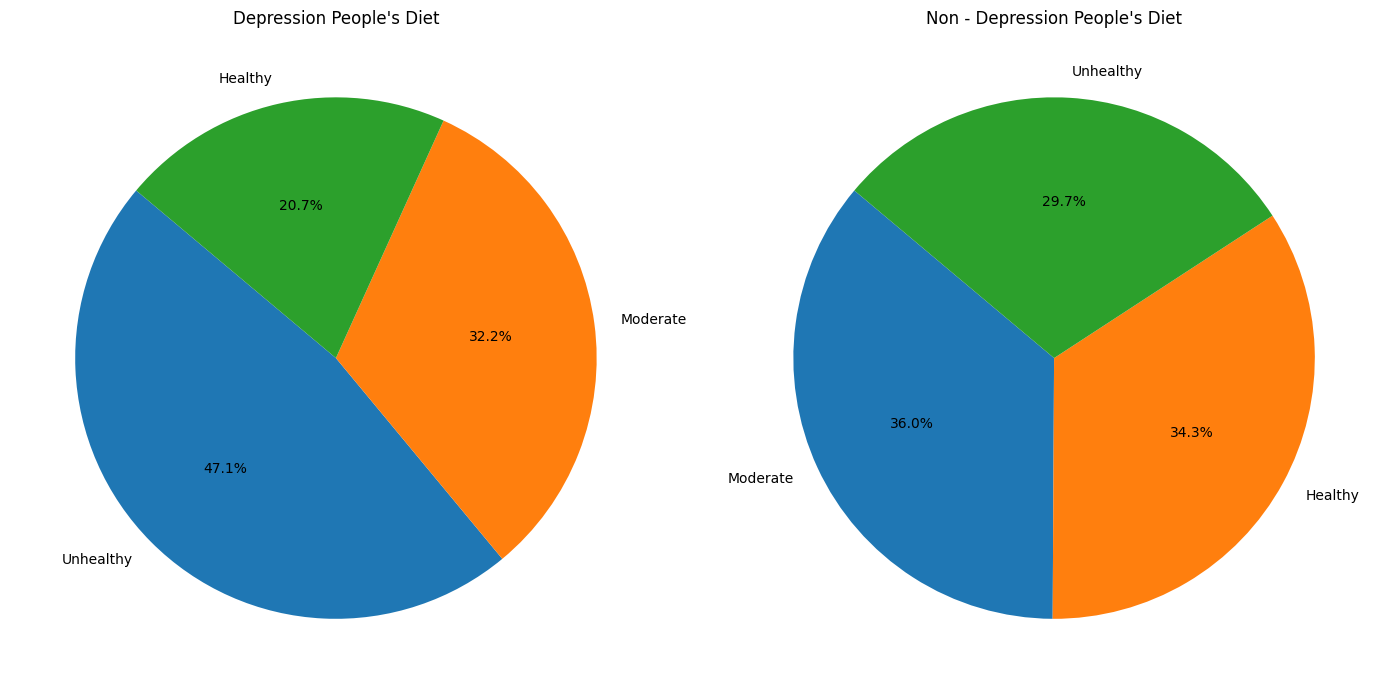

In [ ]:
# Depressed people's diet vs Non-Depressed people's diet with Pie Chart

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

axes[0].pie(
    depressed_diet['Depression'],  
    labels=depressed_diet['Dietary Habits'],
    autopct='%1.1f%%',  
    startangle=140
)
axes[0].set_title("Depression People's Diet")

axes[1].pie(
    non_depressed_diet['Depression'],  
    labels=non_depressed_diet['Dietary Habits'],
    autopct='%1.1f%%',  
    startangle=140  
)
axes[1].set_title("Non - Depression People's Diet")

plt.tight_layout()
plt.show()

In [ ]:
depressed_thoughts = data[data['Depression'] == 1].groupby('Have you ever had suicidal thoughts ?')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_thoughts = data[data['Depression'] == 0].groupby('Have you ever had suicidal thoughts ?')['Depression'].count().sort_values(ascending = False).reset_index()

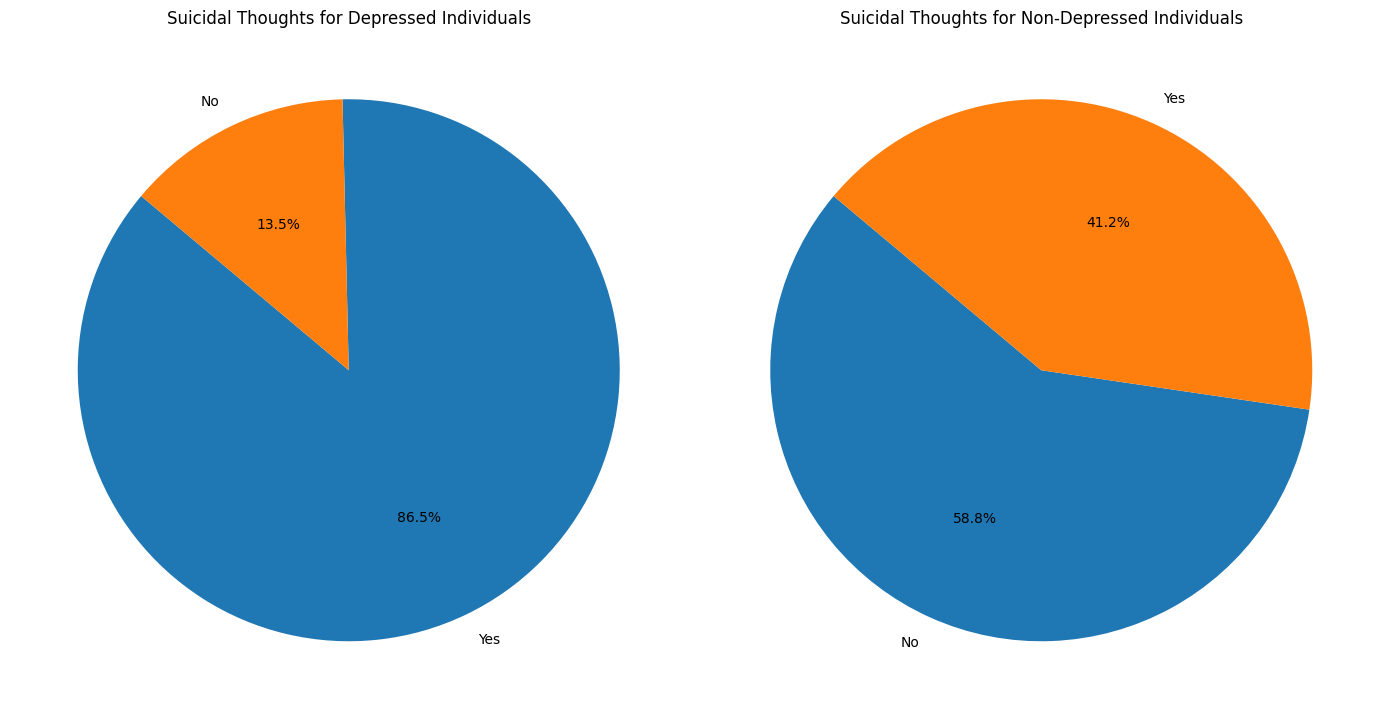

In [ ]:
# Suicidal thoughts distribution with Pie Chart comparison between Depressed and Non-Depressed

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

axes[0].pie(
    depressed_thoughts['Depression'],  
    labels=depressed_thoughts['Have you ever had suicidal thoughts ?'],
    autopct='%1.1f%%',  
    startangle=140
)
axes[0].set_title("Suicidal Thoughts for Depressed Individuals")

axes[1].pie(
    non_depressed_thoughts['Depression'],  
    labels=non_depressed_thoughts['Have you ever had suicidal thoughts ?'],
    autopct='%1.1f%%',  
    startangle=140  
)
axes[1].set_title("Suicidal Thoughts for Non-Depressed Individuals")

plt.tight_layout()
plt.show()

In [ ]:
depressed_work_hr = data[data['Depression'] == 1].groupby('Work/Study Hours')['Depression'].count().sort_values(ascending = False).reset_index().head(10)
non_depressed_work_hr = data[data['Depression'] == 0].groupby('Work/Study Hours')['Depression'].count().sort_values(ascending = False).reset_index().head(10)

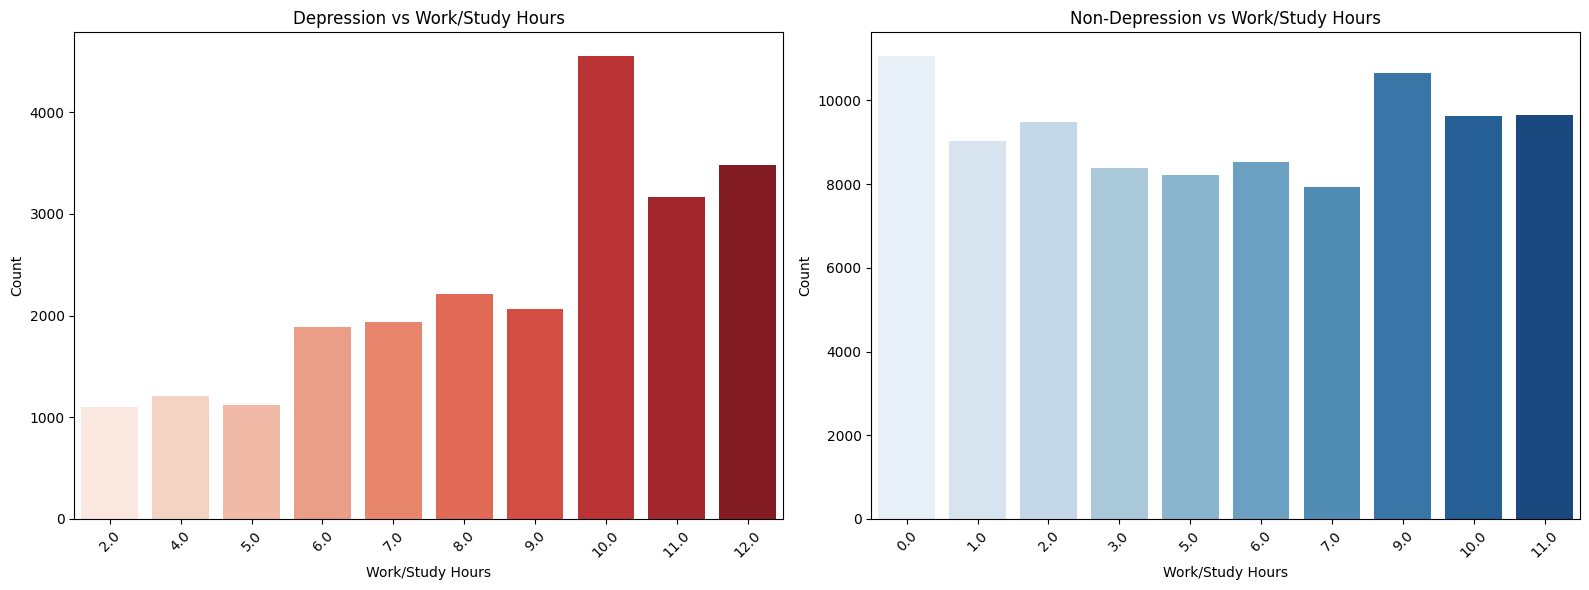

In [ ]:
# Depression vs Non-Depression Work/Study Hours with Bar Plot

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=depressed_work_hr, x='Work/Study Hours', y='Depression', ax=axes[0], palette='Reds')
axes[0].set_title("Depression vs Work/Study Hours")
axes[0].set_xlabel("Work/Study Hours")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=non_depressed_work_hr, x='Work/Study Hours', y='Depression', ax=axes[1], palette='Blues')
axes[1].set_title("Non-Depression vs Work/Study Hours")
axes[1].set_xlabel("Work/Study Hours")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
depressed_lineage = data[data['Depression'] == 1].groupby('Family History of Mental Illness')['Depression'].count().sort_values(ascending = False).reset_index()
non_depressed_lineage = data[data['Depression'] == 0].groupby('Family History of Mental Illness')['Depression'].count().sort_values(ascending = False).reset_index()

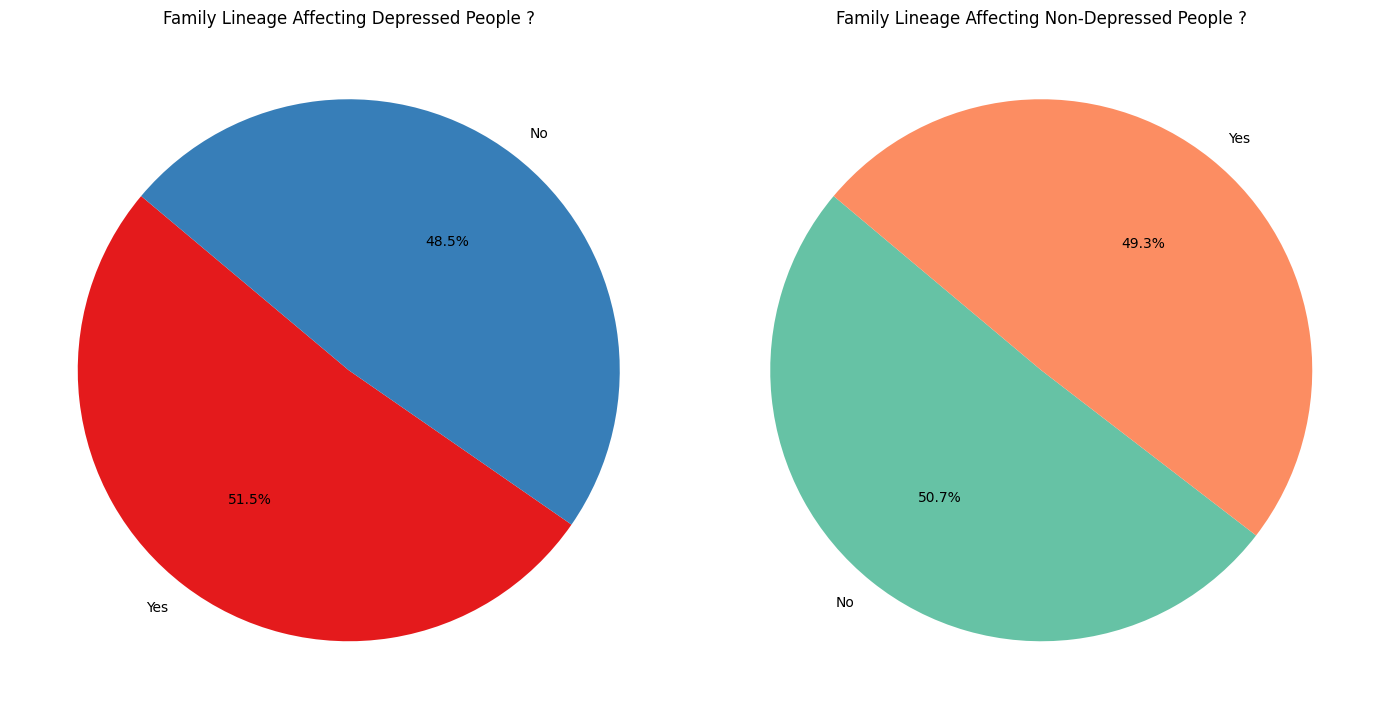

In [ ]:
# Family History of Mental Illness distribution with Pie Chart comparison between Depressed and Non-Depressed

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

axes[0].pie(
    depressed_lineage['Depression'],  
    labels=depressed_lineage['Family History of Mental Illness'],
    autopct='%1.1f%%',  
    startangle=140,
    colors=plt.cm.Set1.colors
)
axes[0].set_title("Family Lineage Affecting Depressed People ?")

axes[1].pie(
    non_depressed_lineage['Depression'],  
    labels=non_depressed_lineage['Family History of Mental Illness'],
    autopct='%1.1f%%',  
    startangle=140,
    colors=plt.cm.Set2.colors  
)
axes[1].set_title("Family Lineage Affecting Non-Depressed People ?")

plt.tight_layout()
plt.show()

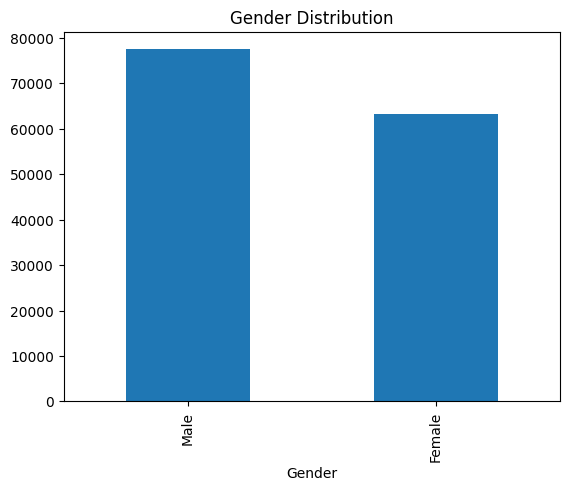

In [ ]:
# Bias Fairness

data["Gender"].value_counts().plot(kind="bar", title="Gender Distribution")
plt.show()

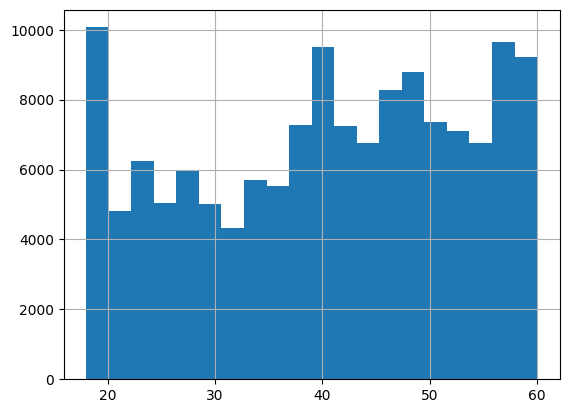

In [ ]:
data["Age"].hist(bins=20)
plt.show()

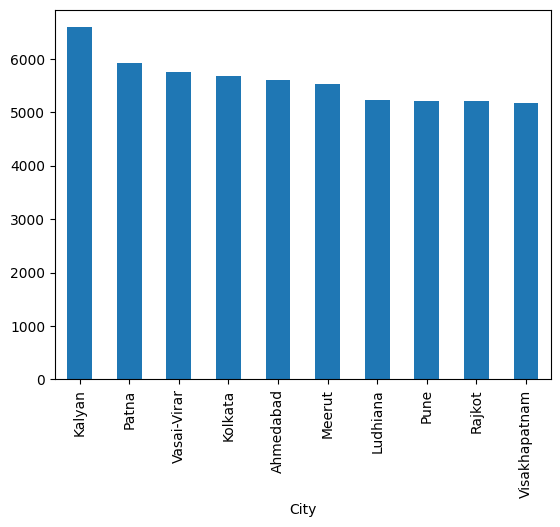

In [ ]:
data["City"].value_counts().head(10).plot(kind="bar")
plt.show()